---
***The 11th Computational Neuroscience Winter School***

# Tutorial I: Dimension Reduction - Principal Component Analysis

__Date:__ Jan. 19, 2022

__Content Creator:__ Kai Chen

*Adapted from Neuromatch Academy-CN*

---
# Tutorial Objectives

In this notebook, we'll start with a brief discussion about why we need dimension reduction and then learn how to perform PCA by projecting the data onto the eigenvectors of its covariance matrix.

Overview:
- Why we need dimension reduction.
- Geometric point of view and information point of view for PCA
- Perform PCA by projecting data onto the eigenvectors of the covariance matrix. 
- Plot and explore the eigenvalues.

To quickly refresh your knowledge of eigenvalues and eigenvectors, you can watch this [short video](https://www.youtube.com/watch?v=kwA3qM0rm7c) (4 minutes) for a geometrical explanation. For a deeper understanding, this [in-depth video](https://www.bilibili.com/video/BV1ys411472E?p=14) (17 minutes) provides an excellent basis and is beautifully illustrated.

---
# Setup

In [1]:
# @title Import most modules and functions needed
import ipywidgets as widgets
%config InlineBackend.figure_format = 'retina'
import numpy as np 
import matplotlib.pyplot as plt

plt_style = {
    'figure.figsize' : (8, 6),
    'figure.autolayout' : True,
    'font.size' : 15,
    'lines.linewidth' : 2,
    'xtick.labelsize' : 'small',
    'ytick.labelsize' : 'small',
    'legend.fontsize' : 'small',
    'axes.spines.top' : False,
    'axes.spines.right' : False,
    'xtick.major.size' : 5,
    'ytick.major.size' : 5,
    'legend.fontsize' : 14,
    'axes.labelsize' : 16,
    'axes.titlesize' : 18,
    }
for key, val in plt_style.items():
    plt.rcParams[key] = val

In [2]:
# @title Helper functions

def plot_eigenvalues(evals):
    """
    Plots eigenvalues.

    Args:
      (numpy array of floats) : Vector of eigenvalues

    Returns:
    Nothing.

    """
    fig = plt.figure(figsize=(4,4))
    plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
    plt.xlabel('Component')
    plt.ylabel('Eigenvalue')
    plt.title('Scree plot')
    plt.xticks(np.arange(1, len(evals) + 1))
    plt.ylim([0, 2.5])


def sort_evals_descending(evals, evectors):
    """
    Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
    eigenvectors to be in first two quadrants (if 2D).

    Args:
    evals (numpy array of floats)    : Vector of eigenvalues
    evectors (numpy array of floats) : Corresponding matrix of eigenvectors
                                        each column corresponds to a different
                                        eigenvalue

    Returns:
    evals (numpy array of floats)    : Vector of eigenvalues after sorting
    evectors (numpy array of floats) : Matrix of eigenvectors after sorting
    """

    index = np.flip(np.argsort(evals))
    evals = evals[index]
    evectors = evectors[:, index]
    if evals.shape[0] == 2:
        if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
            evectors[:, 0] = -evectors[:, 0]
        if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:
            evectors[:, 1] = -evectors[:, 1]
    return evals, evectors


def plot_data(X):
    """
    Plots bivariate data. Includes a plot of each random variable, and a scatter
    scatter plot of their joint activity. The title indicates the sample
    correlation calculated from the data.

    Args:
    X (numpy array of floats) : Data matrix each column corresponds to an
                                individual measurement.

    Returns:
    Nothing.
    """

    fig = plt.figure(figsize=[4, 4])
    ax = fig.add_subplot()
    ax.plot(X[0], X[1], '.', markerfacecolor=[.5, .5, .5],
          markeredgewidth=0)
    ax.axis('equal')
    plt.xlabel('Neuron 1 activity')
    plt.ylabel('Neuron 2 activity')
    plt.title('Sample corr: {:.1f}'.format(np.corrcoef(X[0], X[1])[0, 1]))
    plt.show()


def get_data(cov_matrix):
    """
    Returns a matrix of 1000 samples from a bivariate, zero-mean Gaussian

    Args:
    var_1 (scalar)                     : variance of the first random variable
    var_2 (scalar)                     : variance of the second random variable
    cov_matrix (numpy array of floats) : desired covariance matrix

    Returns:
    (numpy array of floats)            : samples from the bivariate Gaussian,
                                          with each column corresponding to an
                                          individual sample bivariate Gaussian.
    """

    mean = np.array([0, 0])
    X = np.random.multivariate_normal(mean, cov_matrix, size=1000)
    return X.T


def calculate_cov_matrix(var_1, var_2, corr_coef):
    """
    Calculates the covariance matrix based on the variances and
    correlation coefficient.

    Args:
    var_1 (scalar)                    :  variance of the first random variable
    var_2 (scalar)                    :  variance of the second random variable
    corr_coef (scalar)                :  correlation coefficient

    Returns:
    cov_matrix(numpy array of floats) : covariance matrix
    """
    cov = corr_coef * np.sqrt(var_1 * var_2)
    cov_matrix = np.array([[var_1, cov], [cov, var_2]])
    return cov_matrix


def define_orthonormal_basis(u):
    """
    Calculates an orthonormal basis given an arbitrary vector u.

    Args:
    u (numpy array of floats) : arbitrary 2D vector used for new basis

    Returns:
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors
    """

    u = u / np.sqrt(u[0] ** 2 + u[1] ** 2)
    w = np.array([-u[1], u[0]])
    W = np.column_stack((u, w))
    return W


def plot_data_new_basis(Y):
    """
    Plots bivariate data after transformation to new bases. 
    The title indicates the sample correlation calculated from the data.

    Args:
    Y (numpy array of floats) : Data matrix in new basis each column 
                                corresponds to an individual measurement

    Returns:
    Nothing.
    """

    fig = plt.figure(figsize=[4, 4])
    ax = fig.add_subplot()
    ax.plot(Y[0], Y[1], '.', color=[.5, .5, .5])
    ax.axis('equal')
    plt.xlabel('Projection basis vector 1')
    plt.ylabel('Projection basis vector 2')
    plt.title('Sample corr: {:.1f}'.format(np.corrcoef(Y[0], Y[1])[0, 1]))
    plt.show()


def change_of_basis(X, W):
    """
    Projects data onto a new basis.

    Args:
    X (numpy array of floats) : Data matrix each column corresponding to an
                                individual sample
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

    Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
    """

    return W.T @ X


def plot_basis_vectors(X, W, ax=None):
    """
    Plots bivariate data as well as new basis vectors.

    Args:
    X (numpy array of floats) : Data matrix each column corresponds to an
                                individual measurement
    W (numpy array of floats) : Square matrix representing new orthonormal
                                basis each column represents a basis vector

    Returns:
    Nothing.
    """

    fig = plt.figure(figsize=[4, 4])
    plt.plot(X[0], X[1], '.', color=[.5, .5, .5], label='Data')
    plt.axis('equal')
    plt.xlabel('Neuron 1 activity')
    plt.ylabel('Neuron 2 activity')
    plt.plot([0, W[0, 0]], [0, W[1, 0]], color='r', linewidth=3,
           label='Basis vector 1')
    plt.plot([0, W[0, 1]], [0, W[1, 1]], color='b', linewidth=3,
           label='Basis vector 2')
    plt.legend()
    plt.show()

---
# Section 1: Why we need dimension reduction?

With the rapid development of neuronal imaging and recording techniques, enormous amout of neural data is generated over these days.

![neuropixel](../imgs/neuropixel.jpg)

### Formulasims:

Suppose we measure neuronal response of N neurons simultanously, denoted as $\mathbf{x}(k)$. $\mathbf{x}$ is a N-dim vector which is the k-th sample (measurement) of all neurons. Each N-dim vector lives in a high dimensional space with N-dim. If we measure $T$ times, then we obtain a $N$ by $T$ matrix of data, $\mathbf X = \left[\mathbf{x}(1), \mathbf{x}(2), \cdots, \mathbf{x}(T)\right]$. 

**How can we analyze such high-dimensional data?**

1. We can directly run analysis in N-dim space.
2. We do dimension reduction. 

We love low dimension.

1. We live in a low dimensional world.
2. Prevent the curse of dimensionality.
3. We can barely do data visualization for data with upto 3 dimensions.
4. Luckily, a lot of high dimensional data does have low dimensional structure.

To show the geometric point of view of dimension reduction as well as concept of PCA, we will use sythatic generated bivariate data as an demenstration.

## Generated bivariate normal data and calculation of the covariance matrix

For general multivariate normal distribution, we have the canonical form:
$$f_{\mathbf{X}}\left(x_{1}, \ldots, x_{k}\right)=\frac{\exp \left(-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^{\mathrm{T}} \boldsymbol{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu})\right)}{\sqrt{(2 \pi)^{k}|\boldsymbol{\Sigma}|}}.$$
And for bivariate cases:
$$f(x, y)=\frac{1}{2 \pi \sigma_{X} \sigma_{Y} \sqrt{1-\rho^{2}}} \exp \left(-\frac{1}{2\left(1-\rho^{2}\right)}\left[\left(\frac{x-\mu_{X}}{\sigma_{X}}\right)^{2}-2 \rho\left(\frac{x-\mu_{X}}{\sigma_{X}}\right)\left(\frac{y-\mu_{Y}}{\sigma_{Y}}\right)+\left(\frac{y-\mu_{Y}}{\sigma_{Y}}\right)^{2}\right]\right),$$
and
$$\boldsymbol{\mu}=\left(\begin{array}{l}\mu_{X} \\ \mu_{Y}\end{array}\right), \quad \boldsymbol{\Sigma}=\left(\begin{array}{cc}\sigma_{X}^{2} & \rho \sigma_{X} \sigma_{Y} \\ \rho \sigma_{X} \sigma_{Y} & \sigma_{Y}^{2}\end{array}\right),$$
where $\rho$ is the correlation coefficent of between $X$ and $Y$. Now let's generate some synthatic data according to its distribution function.


**Steps**
* Use `calculate_cov_matrix` to design the covariance matrix of synthatic data.
* Use `get_data` to generate bivariate normal data.
* Use `plot_data` to see the pattern of distribution in 2-D plane.


In [22]:
help(calculate_cov_matrix)
help(get_data)
help(plot_data)

Help on function calculate_cov_matrix in module __main__:

calculate_cov_matrix(var_1, var_2, corr_coef)
    Calculates the covariance matrix based on the variances and
    correlation coefficient.
    
    Args:
    var_1 (scalar)                    :  variance of the first random variable
    var_2 (scalar)                    :  variance of the second random variable
    corr_coef (scalar)                :  correlation coefficient
    
    Returns:
    cov_matrix(numpy array of floats) : covariance matrix

Help on function get_data in module __main__:

get_data(cov_matrix)
    Returns a matrix of 1000 samples from a bivariate, zero-mean Gaussian
    
    Args:
    var_1 (scalar)                     : variance of the first random variable
    var_2 (scalar)                     : variance of the second random variable
    cov_matrix (numpy array of floats) : desired covariance matrix
    
    Returns:
    (numpy array of floats)            : samples from the bivariate Gaussian,
       

true cov matrix:
 [[1.  0.8]
 [0.8 1. ]]


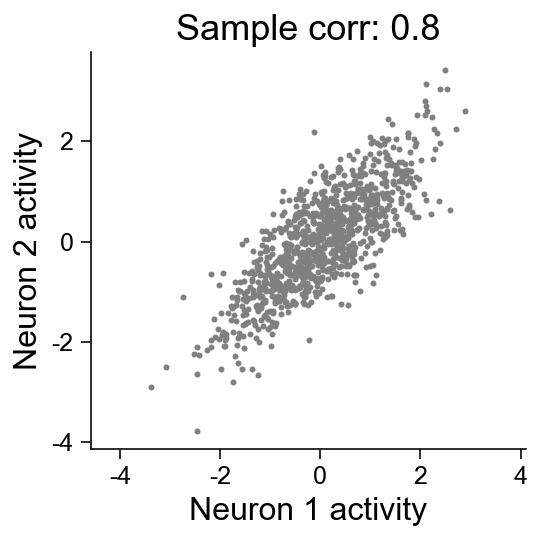

In [23]:
variance_1 = 1
variance_2 = 1
corr_coef = 0.8

np.random.seed(20220119)  # set random seed
cov_matrix = calculate_cov_matrix(variance_1, variance_2, corr_coef)
print('true cov matrix:\n', cov_matrix)

X = get_data(cov_matrix)
plot_data(X)

## Thinkings!

- What is physical meaning of each dot?
- What is the pattern of those dots?
- Can we use one scaler to effectively quantify the difference between dots?


**PCA aims to find new ways to represents data in a new orthonormal basis, which is defined by the eigenvectors of the covariance matrix.**

Commonlly speaking, you don't know the true covariance matrix, how to conquar it in order to perform PCA analysis.

To get around this, we can use the sample covariance matrix, $\bf\hat\Sigma$, which is calculated directly from the data. (**Note: the assumption hidden here is all samples are generated from the same distribution, and the total sample set can reasonably capture the distribution of its nature.**)

If we assume that the data has already been mean-subtracted, i.e., $\bar{x_i}=0$, then we can write the sample covariance matrix in a much simpler matrix form:

\begin{align}
{\bf \hat \Sigma}
&= \frac{1}{N_\text{samples}} {\bf X} {\bf X}^T.
\end{align}

**Steps:**
* Use the function `get_sample_cov_matrix` to verify the covariance matrix of generated functions.
* Compare this estimate to the true covariate matrix using `calculate_cov_matrix`.

In [24]:
def get_sample_cov_matrix(X):
    """
    Returns the sample covariance matrix of data X

    Args:
    X (numpy array of floats)          : Data matrix each column corresponds to a
                                         different random variable

    Returns:
    cov_matrix (numpy array of floats) : Covariance matrix
    """

    # Subtract the mean of X
    X = ...
    # Calculate the covariance matrix (hint: use np.matmul)
    cov_matrix = ...

    return cov_matrix


sample_cov_matrix = get_sample_cov_matrix(X)
print('true cov matrix:\n', cov_matrix)
print('sample cov matrix:\n', sample_cov_matrix)

true cov matrix:
 [[1.  0.8]
 [0.8 1. ]]
sample cov matrix:
 [[0.99201351 0.79303792]
 [0.79303792 1.00615205]]


---
# Section 2: Calculate the eigenvectors of the the sample covariance matrix


## Eigenvectors of the Covariance matrix

Next we will calculate the eigenvectors of the covariance matrix. Plot them along with the data to check that they align with the geometry of the data.

**Steps:**
* Calculate the eigenvalues and eigenvectors of the sample covariance matrix. (**Hint:** use `np.linalg.eigh`, which finds the eigenvalues of a symmetric matrix).
* Use the provided code to sort the eigenvalues in descending order.
* Plot the eigenvectors on a scatter plot of the data, using the function `plot_basis_vectors`. 

In [15]:
help(sort_evals_descending)
help(plot_basis_vectors)

Help on function sort_evals_descending in module __main__:

sort_evals_descending(evals, evectors)
    Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
    eigenvectors to be in first two quadrants (if 2D).
    
    Args:
    evals (numpy array of floats)    : Vector of eigenvalues
    evectors (numpy array of floats) : Corresponding matrix of eigenvectors
                                        each column corresponds to a different
                                        eigenvalue
    
    Returns:
    evals (numpy array of floats)    : Vector of eigenvalues after sorting
    evectors (numpy array of floats) : Matrix of eigenvectors after sorting

Help on function plot_basis_vectors in module __main__:

plot_basis_vectors(X, W)
    Plots bivariate data as well as new basis vectors.
    
    Args:
    X (numpy array of floats) : Data matrix each column corresponds to an
                                individual measurement
    W (numpy array of floats) :

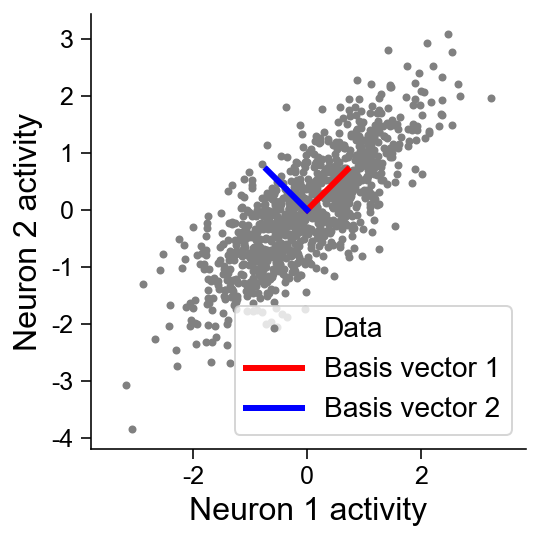

In [16]:
# Calculate the eigenvalues and eigenvectors
evals, evectors = ...
# Sort the eigenvalues in descending order
evals, evectors = ...

plot_basis_vectors(X, evectors)

---
# Section 3: Perform PCA by projecting data onto the eigenvectors


To perform PCA, we will project the data onto the eigenvectors of the covariance matrix, i.e.:
\begin{equation}
\bf Y = W^T X 
\end{equation}
where $\bf Y$ is an $N \times T$ matrix representing the projected data (also called *scores*), and $W$ is an $N\times N$ orthogonal matrix, each of whose columns represents the eigenvectors of the covariance matrix (also called *weights* or *loadings*). 

For each sample, we have
$$
\mathbf{y}_k = \mathbf{W}^\top \mathbf{x}_k = \sum^N \mathbf{w}_i^\top\mathbf{x}_k.
$$


## PCA implementation

We will now perform PCA on the data using the intuition we have developed so far. Fill in the function below to carry out the steps to perform PCA by projecting the data onto the eigenvectors of its covariance matrix.

**Steps:**
* First subtract the mean.
* Then calculate the sample covariance matrix.
* Then find the eigenvalues and eigenvectors and sort them in descending order.
* Finally project the mean-centered data onto the eigenvectors.

In [17]:
help(change_of_basis)
help(plot_data_new_basis)

Help on function change_of_basis in module __main__:

change_of_basis(X, W)
    Projects data onto a new basis.
    
    Args:
    X (numpy array of floats) : Data matrix each column corresponding to an
                                individual sample
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors
    
    Returns:
    (numpy array of floats)   : Data matrix expressed in new basis

Help on function plot_data_new_basis in module __main__:

plot_data_new_basis(Y)
    Plots bivariate data after transformation to new bases. 
    The title indicates the sample correlation calculated from the data.
    
    Args:
    Y (numpy array of floats) : Data matrix in new basis each column 
                                corresponds to an individual measurement
    
    Returns:
    Nothing.



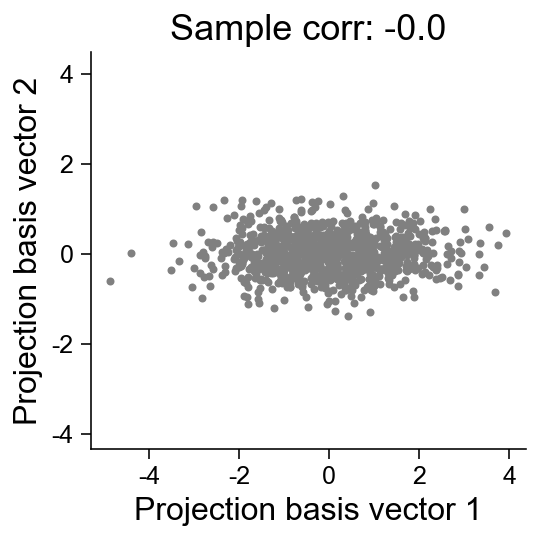

In [18]:
def pca(X):
    """
    Performs PCA on multivariate data.

    Args:
    X (numpy array of floats)          : Data matrix each column corresponds
                                         to a different random variable

    Returns:
    score (numpy array of floats)      : Data projected onto the new basis
    evectors (numpy array of floats)   : Vector of eigenvalues
    evals (numpy array of floats)      : Corresponding matrix of eigenvectors

    """

    # Subtract the mean of X
    X = ...
    # Calculate the sample covariance matrix
    cov_matrix = ...
    # Calculate the eigenvalues and eigenvectors
    evals, evectors = ...
    # Sort the eigenvalues in descending order
    evals, evectors = ...
    # Project the data onto the new eigenvector basis
    score = ...

    return score, evectors, evals


# Perform PCA on the data matrix X
score, evectors, evals = pca(X)
# Plot the data projected into the new basis
plot_data_new_basis(score)

# Section 4: Plot and explore the eigenvalues



   
Finally, we will examine the eigenvalues of the covariance matrix. Remember that each **eigenvalue** describes the **variance** of the data projected onto its corresponding **eigenvector**. This is an important concept because it allows us to rank the PCA basis vectors based on how much variance each one can capture. First run the code below to plot the eigenvalues (sometimes called the "scree plot"). Which eigenvalue is larger?

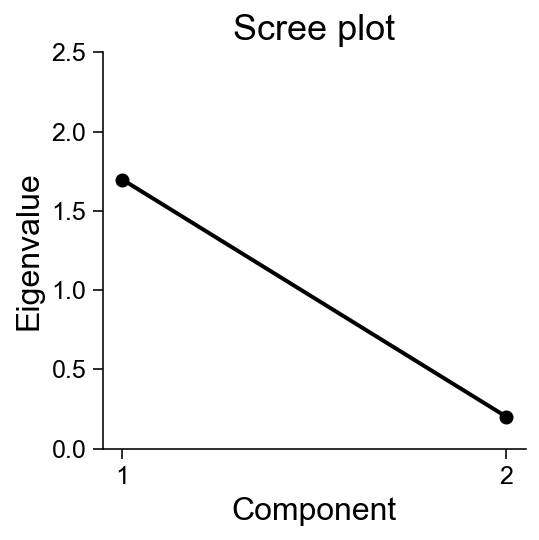

In [25]:
plot_eigenvalues(evals)

## Interactive Demo: Exploration of the correlation coefficient

Run the following cell and use the slider to change the correlation coefficient in the data. You should see the scree plot and the plot of basis vectors update.

**Questions:**
* What happens to the eigenvalues as you change the correlation coefficient?
* Can you find a value for which both eigenvalues are equal?
* Can you find a value for which only one eigenvalue is nonzero?

In [44]:
# @title

# @markdown Make sure you execute this cell to enable the widget!

def refresh(corr_coef=.8):
    cov_matrix = calculate_cov_matrix(variance_1, variance_2, corr_coef)
    X = get_data(cov_matrix)
    score, evectors, evals = pca(X)
    plot_eigenvalues(evals)
    plot_basis_vectors(X, evectors)

_ = widgets.interact(refresh, corr_coef=(-1, 1, .1))

interactive(children=(FloatSlider(value=0.8, description='corr_coef', max=1.0, min=-1.0), Output()), _dom_clas…

---
# Section 5: Play with experimental data!

The Stringer datasets ([bilibili](https://www.bilibili.com/video/BV17g4y1i7zd?from=search&seid=17568688850691704293&spm_id_from=333.337.0.0)) contain simultaneous recordings of 10,000 or 20,000 neurons from mouse visual cortex either during the presentation of gratings or during spontaneous behaviors like running, whisking and sniffing. These datasets are a little more advanced because you have to work with many neurons simultaneously. They are exciting, because they give a taste of what’s to come in neuroscience.

In [3]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [4]:
#@title Data loading
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


dat has fields:
* `dat['sresp']`: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* `dat['run']`: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* `dat['istim']`: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial


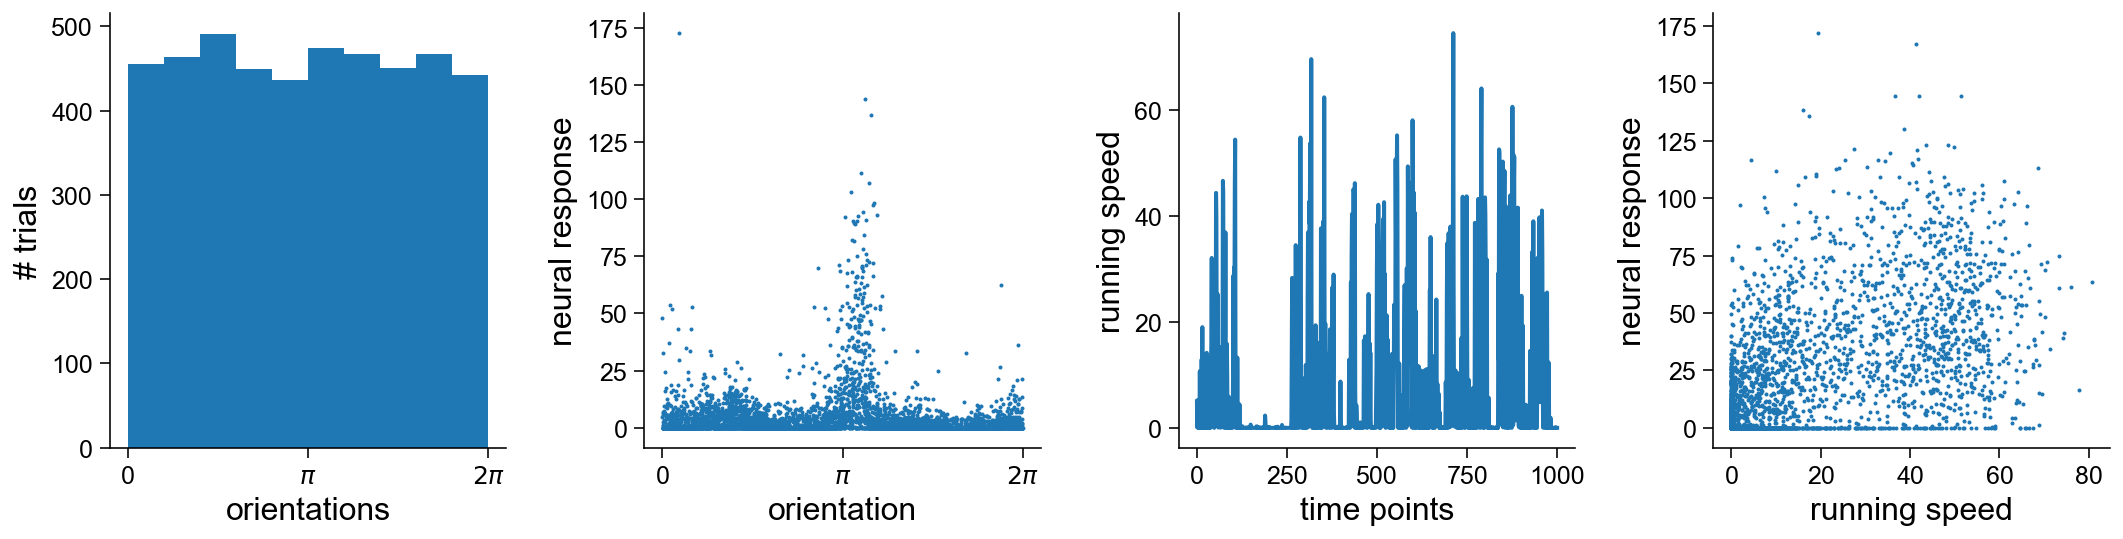

In [5]:
#@title Basic data properties using plot, hist and scatter
fig, axs = plt.subplots(1,4, figsize=(15,4))
axs[0].hist(dat['istim'])
axs[0].set(xlabel='orientations', ylabel = '# trials')
axs[0].set_xticks([0,np.pi, 2*np.pi])
axs[0].set_xticklabels(['0', r'$\pi$', r'$2\pi$'])

axs[1].scatter(dat['istim'], dat['sresp'][1000], s= 1)
axs[1].set(xlabel = 'orientation', ylabel = 'neural response')
axs[1].set_xticks([0,np.pi, 2*np.pi])
axs[1].set_xticklabels(['0', r'$\pi$', r'$2\pi$'])

axs[2].plot(dat['run'][:1000])
axs[2].set(xlabel = 'time points', ylabel = 'running speed')

axs[3].scatter(dat['run'], dat['sresp'][20998], s= 1)
axs[3].set(xlabel = 'running speed', ylabel = 'neural response');



In [44]:
#@title take PCA after preparing data by z-score
from scipy.stats import zscore
from sklearn.decomposition import PCA 
Z = zscore(dat['sresp'], axis=1)
pca = PCA(n_components = 200)
pca.fit(Z.T)
X = pca.transform(Z.T)


Text(0, 0.5, 'Eigenvalue of Covariance matrix')

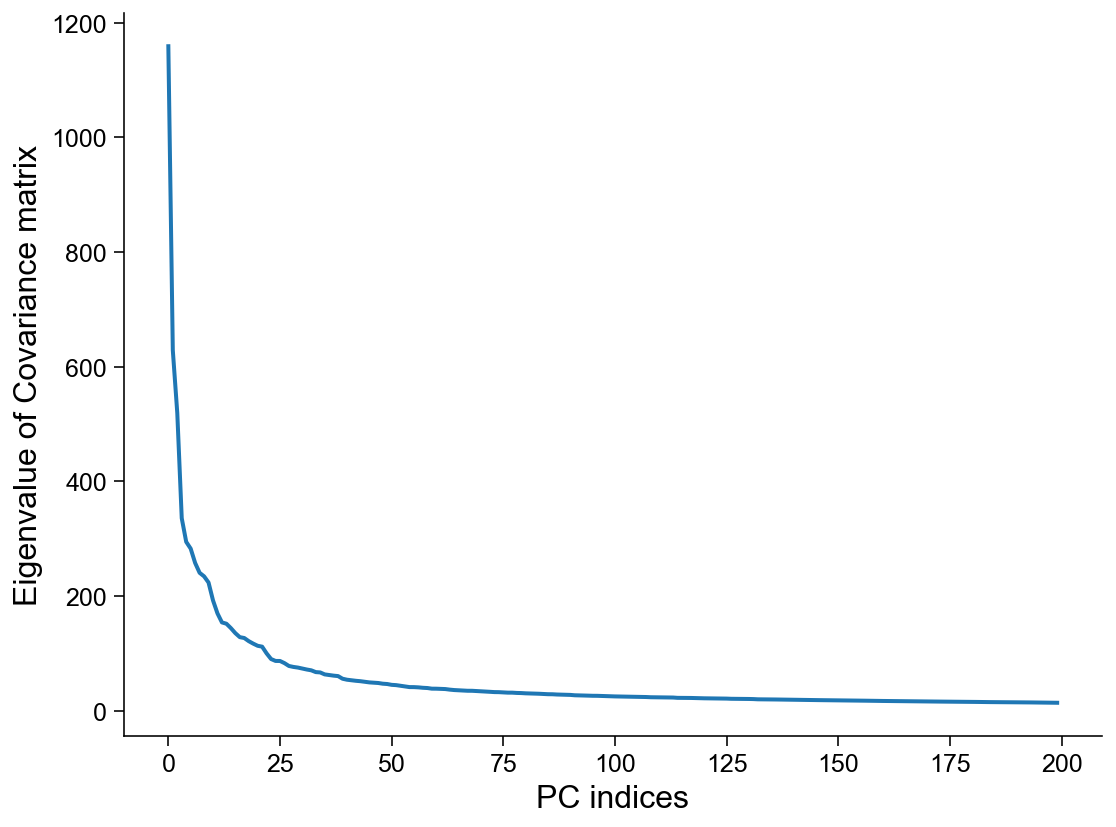

In [59]:
plt.plot(pca.explained_variance_)
plt.xlabel('PC indices')
plt.ylabel('Eigenvalue of Covariance matrix')

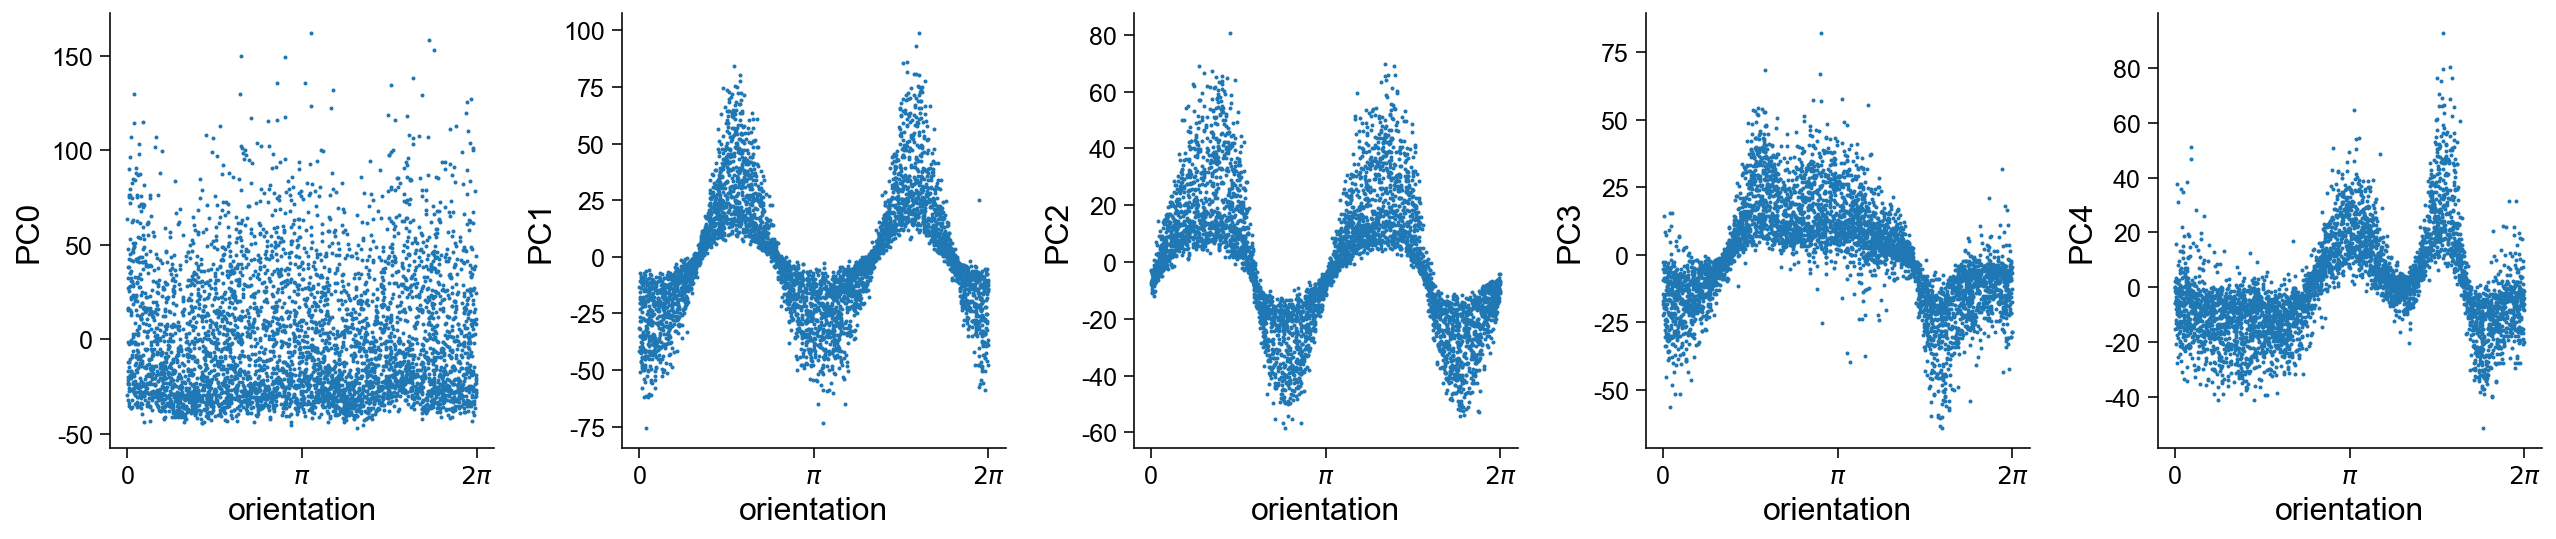

In [53]:
#@title plot PCs as function of stimulus orientation
fig, ax = plt.subplots(1,5,figsize=(18,4))
for j in range(5):
  ax[j].scatter(dat['istim'], X[:,j], s = 1)
  ax[j].set(xlabel='orientation', ylabel = 'PC%d'%j)
  ax[j].set_xticks([0,np.pi, 2*np.pi])
  ax[j].set_xticklabels(['0', r'$\pi$', r'$2\pi$'])

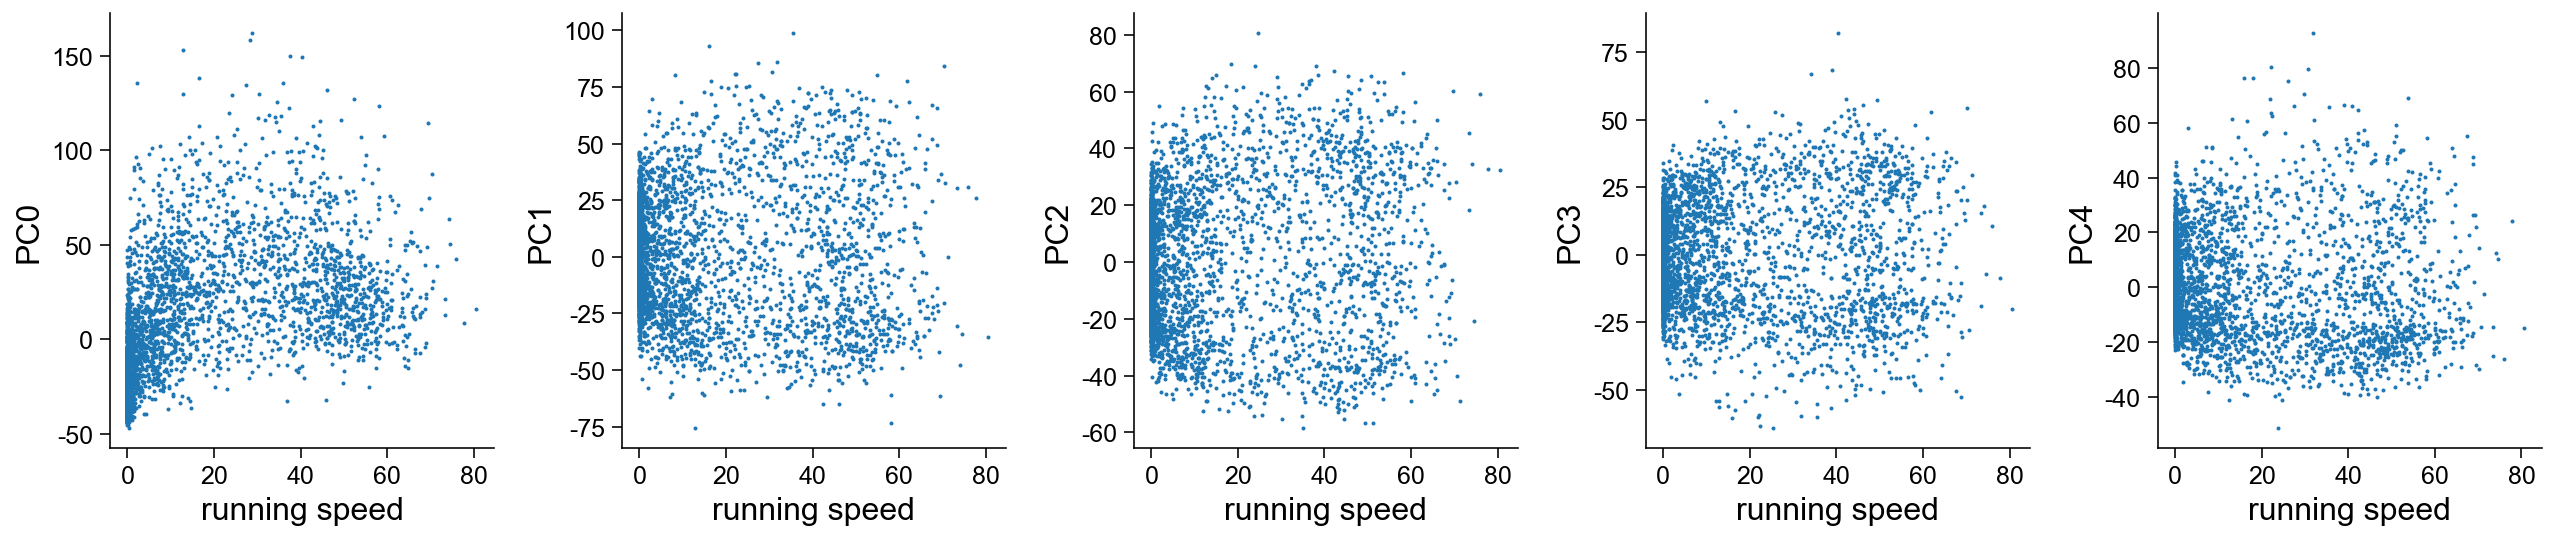

In [32]:
#@title plot PCs as function of running speed
fig, ax = plt.subplots(1,5,figsize=(18,4))
for j in range(5):
  ax[j].scatter(dat['run'], X[:,j], s = 1)
  ax[j].set(xlabel='running speed', ylabel = 'PC%d'%j)

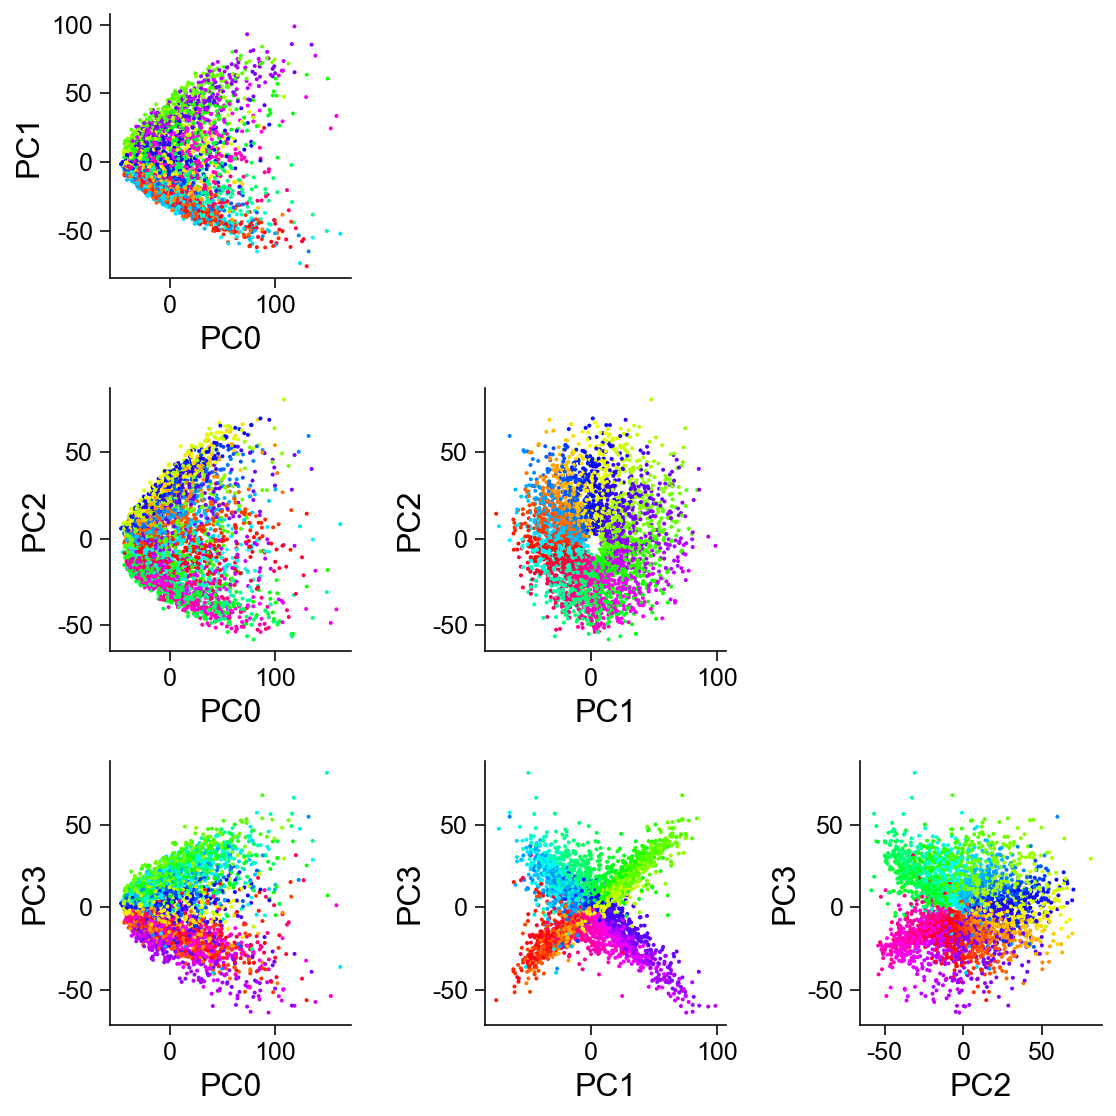

In [34]:
#@title plot in PC space colored with stimulus orientation
fig, ax = plt.subplots(3,3,figsize=(8,8))
[axi.axis('off') for axi in ax.flatten()]
pc_indices = (((0,1), (0,2), (0,3), (1,2), (1,3), (2,3)))
for j, idx in enumerate(pc_indices):
    ax[idx[1]-1, idx[0]].scatter(X[:,idx[0]], X[:,idx[1]],c=dat['istim'], s = 1, cmap = 'hsv')
    ax[idx[1]-1, idx[0]].set(xlabel=f'PC{idx[0]:d}', ylabel=f'PC{idx[1]:d}')
    ax[idx[1]-1, idx[0]].axis('on')
plt.tight_layout()

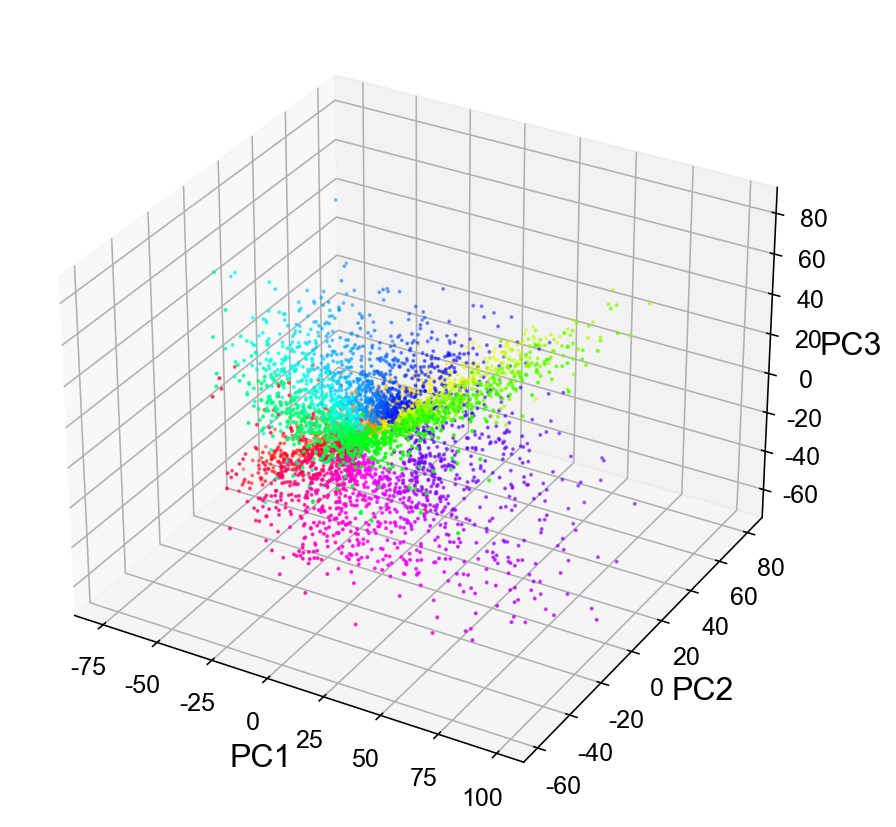

In [29]:
# @title plot the 3D positions of all neurons
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,1],X[:,2],X[:,3], s = 1, c = dat['istim'], cmap='hsv')
ax.set(xlabel='PC1', ylabel = 'PC2', zlabel='PC3');

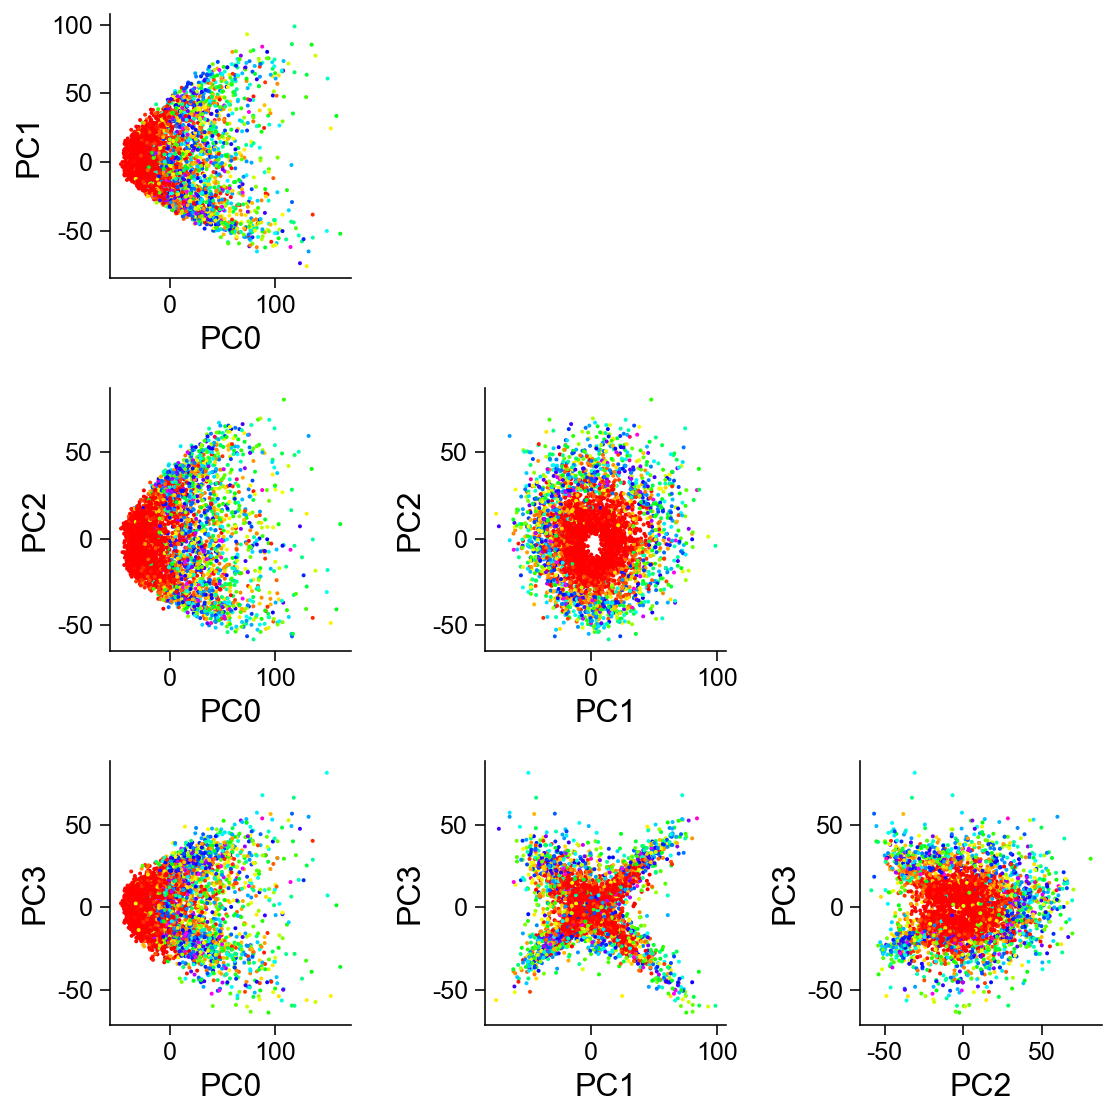

In [33]:
#@title plot in PC space colored with stimulus orientation
fig, ax = plt.subplots(3,3,figsize=(8,8))
[axi.axis('off') for axi in ax.flatten()]
pc_indices = (((0,1), (0,2), (0,3), (1,2), (1,3), (2,3)))
for j, idx in enumerate(pc_indices):
    ax[idx[1]-1, idx[0]].scatter(X[:,idx[0]], X[:,idx[1]],c=dat['run'], s = 1, cmap = 'hsv')
    ax[idx[1]-1, idx[0]].set(xlabel=f'PC{idx[0]:d}', ylabel=f'PC{idx[1]:d}')
    ax[idx[1]-1, idx[0]].axis('on')
plt.tight_layout()

In [18]:
# !pip install umap-learn --quiet

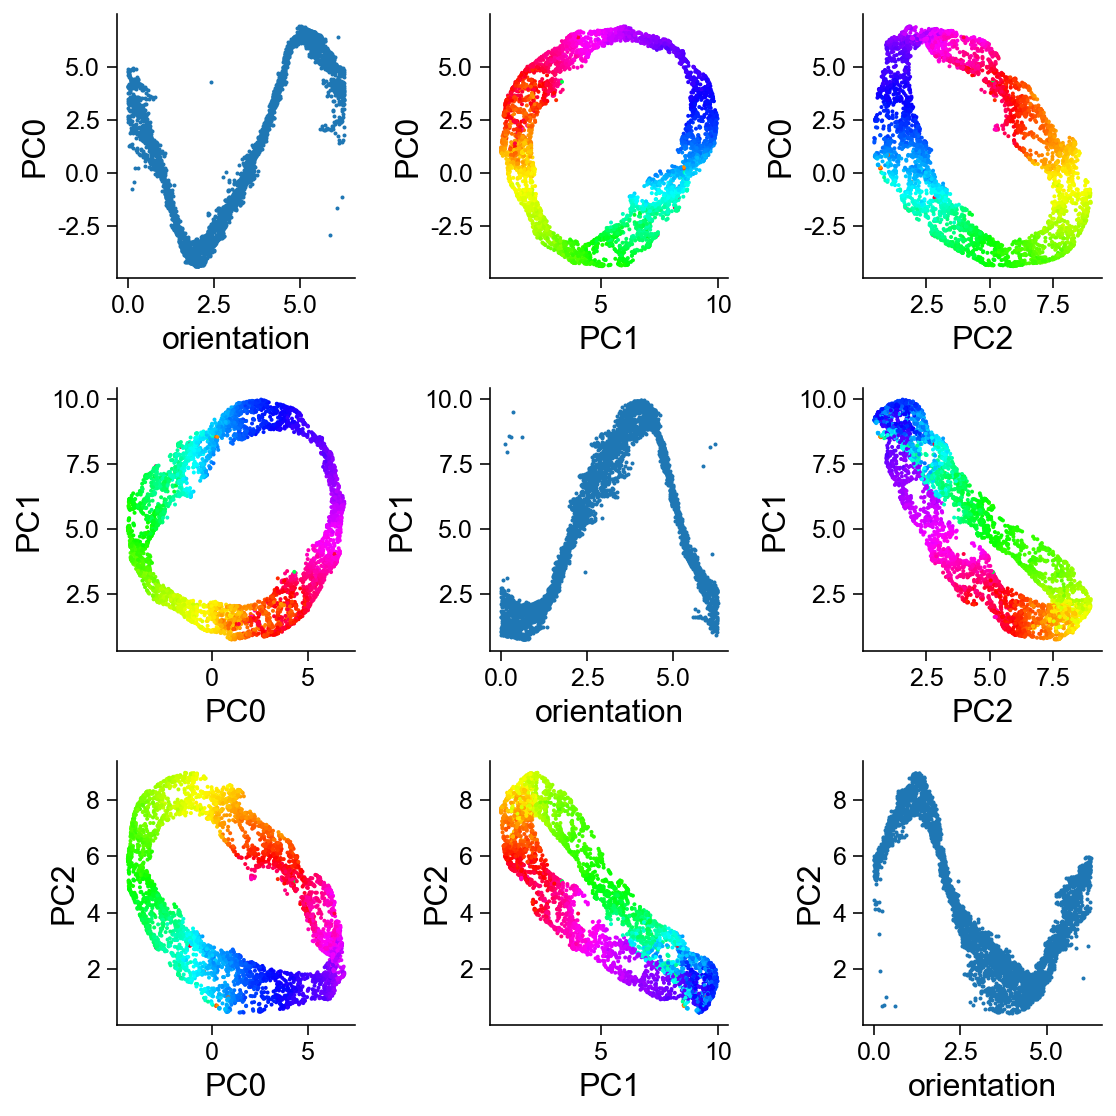

In [39]:
#@title run a manifold embedding algorithm (UMAP) in two or three dimensions. 
from umap import UMAP

ncomp = 3 # try 2, then try 3
xinit = 3 * zscore(X[:,:ncomp], axis=0)
embed = UMAP(n_components=ncomp, init =  xinit, n_neighbors = 25, 
             metric = 'correlation', transform_seed = 42).fit_transform(X)

fig, ax = plt.subplots(ncomp, ncomp, figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    if i==j:
      ax[i,j].scatter(dat['istim'], embed[:,i], s  = 1)
      ax[i,j].set(xlabel=f'orientation', ylabel=f'PC{i:d}')
    else:
      ax[i,j].scatter(embed[:,j], embed[:,i], s  = 1, c= dat['istim'], cmap = 'hsv')
      ax[i,j].set(xlabel=f'PC{j:d}', ylabel=f'PC{i:d}')

plt.tight_layout()


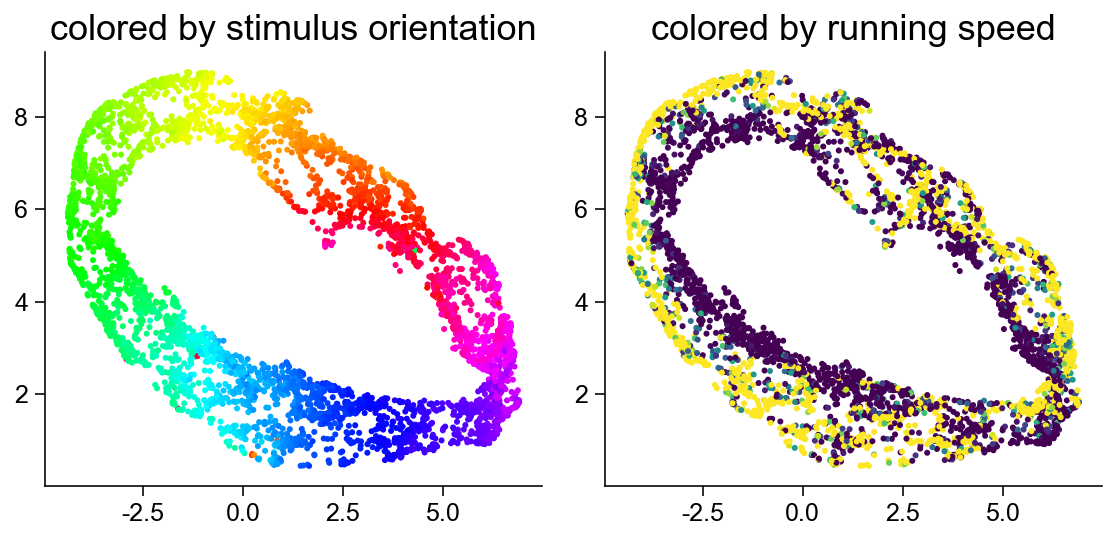

In [43]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].scatter(embed[:,0], embed[:,2], s  = 4, c= dat['istim'], cmap = 'hsv')
ax[0].set_title('colored by stimulus orientation');
ax[1].scatter(embed[:,0], embed[:,2], s  = 4, c= dat['run'], vmin = 0, vmax = 10)
ax[1].set_title('colored by running speed');

---
# Summary

- In this tutorial, we discuss the necessity of dimension reduction.
- We learned that goal of PCA is to find an orthonormal basis capturing the directions of maximum variance of the data. More precisely, the $i$th basis vector is the direction that maximizes the projected variance, while being orthogonal to all previous basis vectors. Mathematically, these basis vectors are the eigenvectors of the covariance matrix (also called *loadings*). 
- The projected variance along each basis vector is given by its corresponding eigenvalue. This is important because it allows us rank the "importance" of each basis vector in terms of how much of the data variability it explains. An eigenvalue of zero means there is no variation along that direction so it can be dropped without losing any information about the original data.
- For application with experimental data, PCA can help us capture the low dimensional manifold hidden in high dimensional state space. 
- PCA gives us intuitions about population coding strategeis.
- Other nonlinear version of PCA-like algorithm for dimension reduction might required for data with nonlinear embedding structures.
